<a href="https://colab.research.google.com/github/AnnacKK/Projects/blob/main/Stoke_predictions_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization,LSTM,Bidirectional
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.utils import Sequence
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from sklearn import linear_model

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
data = pd.read_csv("/content/gdrive/MyDrive/NL/input/NFLX.csv")
data["Date"]=pd.to_datetime(data["Date"])
data.set_index('Date', inplace=True)
data.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900
5,2018-02-12,252.139999,259.149994,249.000000,257.950012,257.950012,8534900
6,2018-02-13,257.290009,261.410004,254.699997,258.269989,258.269989,6855200
7,2018-02-14,260.470001,269.880005,260.329987,266.000000,266.000000,10972000
8,2018-02-15,270.029999,280.500000,267.630005,280.269989,280.269989,10759700
9,2018-02-16,278.730011,281.959991,275.690002,278.519989,278.519989,8312400


In [ ]:
def check_data(data):
  duples=data.duplicated().sum()
  empty=data.isnull().sum()
  info=data.info()
  print("duples:",duples, "empty:",empty)
check_data(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1009 non-null   object 
 1   Open       1009 non-null   float64
 2   High       1009 non-null   float64
 3   Low        1009 non-null   float64
 4   Close      1009 non-null   float64
 5   Adj Close  1009 non-null   float64
 6   Volume     1009 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 55.3+ KB
duples: 0 empty: Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
#datatime=pd.DataFrame(data['Date'])
#data["Date"]=pd.to_datetime(datatime["Date"])
#data.drop(columns="Date", inplace=True)
data["year"]=[d.year for d in data.index]
data["month"]=[d.strftime('%b') for d in data.index]
data

,Open,High,Low,Close,Adj Close,Volume,year,month
Date,,,,,,,,
2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100,2018,Feb
2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800,2018,Feb
2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500,2018,Feb
2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700,2018,Feb
2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900,2018,Feb
...,...,...,...,...,...,...,...,...
2022-01-31,401.970001,427.700012,398.200012,427.140015,427.140015,20047500,2022,Jan
2022-02-01,432.959991,458.480011,425.540009,457.130005,457.130005,22542300,2022,Feb
2022-02-02,448.250000,451.980011,426.480011,429.480011,429.480011,14346000,2022,Feb


In [ ]:
data.drop(columns="Date", inplace=True)

<AxesSubplot:xlabel='year', ylabel='Adj Close'>

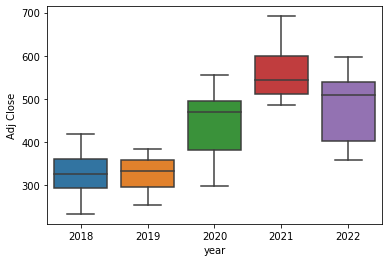

In [ ]:
sns.boxplot(x=datatime["year"],y=data["Adj Close"])

<AxesSubplot:xlabel='month', ylabel='Adj Close'>

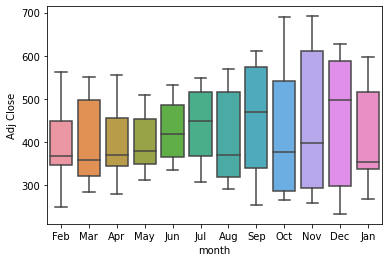

In [ ]:
sns.boxplot(x=datatime["month"],y=data["Adj Close"])

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
Adj_decompose=seasonal_decompose(data["Adj Close"],model="additive",period=1)

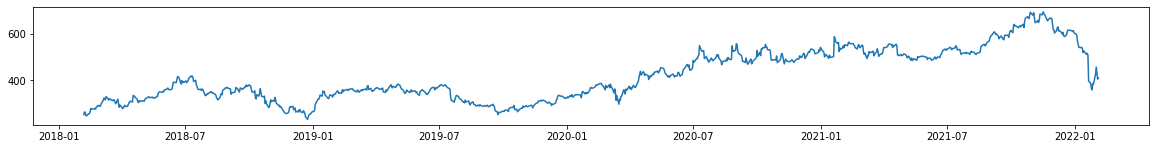

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(411)
plt.plot(Adj_decompose.trend)


In [ ]:
x_features=['Open', 'High', 'Low', 'Volume','Adj Close']
scaler=MinMaxScaler()
scaler.fit(data[x_features])
data=pd.DataFrame(scaler.transform(data[x_features]),columns=x_features)

x_features=['Open', 'High', 'Low', 'Volume']
data_train=data[x_features]

data

,Open,High,Low,Volume,Adj Close
0,0.061253,0.038304,0.041331,0.186150,0.044516
1,0.030059,0.035640,0.030273,0.198264,0.069548
2,0.071243,0.048408,0.072770,0.135690,0.067015
3,0.072334,0.037683,0.041265,0.141320,0.035430
4,0.043474,0.011436,0.010729,0.272902,0.034053
...,...,...,...,...,...
1004,0.366577,0.393147,0.367080,0.327275,0.422140
1005,0.434178,0.461496,0.427186,0.370467,0.487648
1006,0.467531,0.447062,0.429253,0.228565,0.427251
1007,0.409048,0.396611,0.380447,0.151682,0.375090


In [ ]:
timesplit = TimeSeriesSplit(n_splits=8)
for train_index, test_index in timesplit.split(data_train):
        X_train, X_test = data_train[:len(train_index)], data_train[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = data["Adj Close"][:len(train_index)].values.ravel(), data["Adj Close"][len(train_index): (len(train_index)+len(test_index))].values.ravel()
trainX =np.array(X_train)
testX =np.array(X_test)
X_train = trainX.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testX.reshape(X_test.shape[0], 1, X_test.shape[1])

In [ ]:
X_train.shape

(897, 1, 4)

In [ ]:
data_train.shape

(1009, 4)

In [ ]:
lstm = Sequential()
lstm.add(Bidirectional(LSTM(128, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=True)))
lstm.add(Dropout(0.3))
lstm.add(Bidirectional(LSTM(64, activation='relu', return_sequences=True)))
lstm.add(Dropout(0.2))
lstm.add(Bidirectional(LSTM(64, activation='relu', return_sequences=False)))
lstm.add(Dropout(0.2))
lstm.add(Dense(1))
lstm.compile(loss='mse', optimizer='adam',metrics=['accuracy'])

In [ ]:
callback = EarlyStopping(
    monitor="loss",
    patience=4,
    restore_best_weights=True
)

In [ ]:

model = lstm.fit(X_train,
                    y_train,
                    verbose=1,
                    batch_size=16,
                    epochs=50,
                    callbacks=[callback]
                   )

Epoch 1/50
57/57 [==============================] - 13s 15ms/step - loss: 0.0781 - accuracy: 0.0011
Epoch 2/50
57/57 [==============================] - 1s 15ms/step - loss: 0.0056 - accuracy: 0.0011
Epoch 3/50
57/57 [==============================] - 1s 15ms/step - loss: 0.0030 - accuracy: 0.0011
Epoch 4/50
57/57 [==============================] - 1s 15ms/step - loss: 0.0030 - accuracy: 0.0011
Epoch 5/50
57/57 [==============================] - 1s 15ms/step - loss: 0.0020 - accuracy: 0.0011
Epoch 6/50
57/57 [==============================] - 1s 15ms/step - loss: 0.0019 - accuracy: 0.0011
Epoch 7/50
57/57 [==============================] - 1s 15ms/step - loss: 0.0023 - accuracy: 0.0011
Epoch 8/50
57/57 [==============================] - 1s 15ms/step - loss: 0.0018 - accuracy: 0.0011
Epoch 9/50
57/57 [==============================] - 1s 16ms/step - loss: 0.0017 - accuracy: 0.0011
Epoch 10/50
57/57 [==============================] - 1s 23ms/step - loss: 0.0019 - accuracy: 0.0011
Epoch 11

In [ ]:
y_pred = lstm.predict(X_test)

4/4 [==============================] - 1s 6ms/step


In [ ]:
MAE = metrics.mean_absolute_error(y_test, y_pred)
MAE


0.019048043197957793

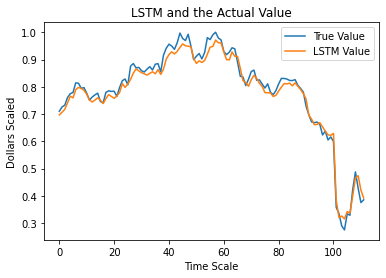

In [ ]:
#
plt.plot(y_test, label='True Value')
plt.plot(y_pred, label='LSTM Value')
plt.title("LSTM and the Actual Value")
plt.xlabel('Time Scale')
plt.ylabel('Dollars Scaled')
plt.legend()
plt.show()

In [ ]:

test=pd.DataFrame(columns=['test','pred'])
test['test']=y_test
test['pred']=y_pred.flatten()
test

,test,pred
0,0.709989,0.696809
1,0.725847,0.706458
2,0.732422,0.717165
3,0.760556,0.740638
4,0.774710,0.765451
...,...,...
107,0.422140,0.399302
108,0.487648,0.466157
109,0.427251,0.473592
110,0.375090,0.420702


Text(4, 0.35, 'Mean Absolute error : 0.00053')

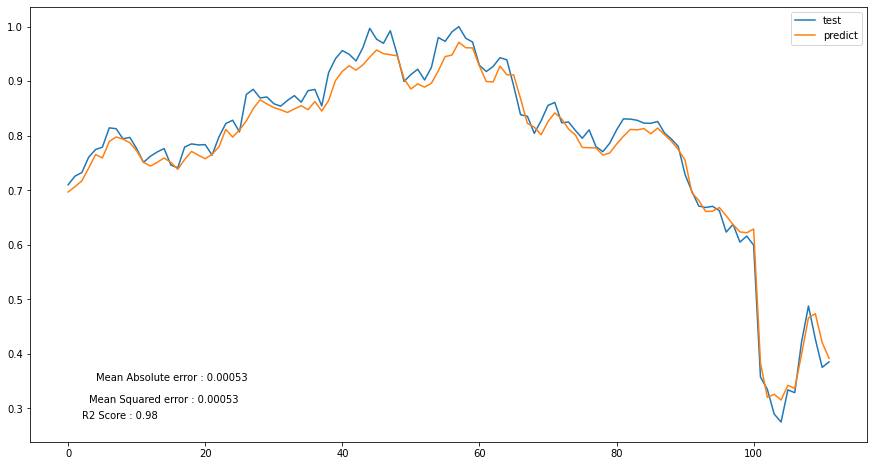

In [ ]:

fig=plt.figure(figsize=(15,8))
#plt.title("Test vs Predicted value", size=20, weight='bold')
plt.plot(test)
plt.legend(['test','predict'])
r2=np.round(r2_score(y_test,y_pred),2)
mse=np.round(mean_squared_error(y_test,y_pred),5)
mae=np.round(mean_squared_error(y_test,y_pred),5)
plt.text(x=2, y=0.28,s='R2 Score : {}'.format(r2))
plt.text(x=3, y=0.31,s='Mean Squared error : {}'.format(mse))
plt.text(x=4, y=0.35,s='Mean Absolute error : {}'.format(mae))